In [1]:
import numpy as np
import astropy.io.fits as fits
import scipy.optimize as op
import pylab as plt

In [2]:
%matplotlib inline

In [3]:
data = fits.open("matched_gaia_galah.fits",ignore_missing_end=True)[1].data
dist = 1. / data['PARALLAX']
lon = data['l'] * np.pi / 180
lat = data['b'] * np.pi / 180

gcdist = 8.5
xs = np.array(dist * np.cos(lat) * np.cos(lon))
ys = np.array(dist * np.cos(lat) * np.sin(lon))
zs = np.array(dist * np.sin(lat))
galrs = ((gcdist - xs) ** 2 + ys ** 2) ** 0.5
xs = np.vstack([xs, ys, zs]).T
galrs.shape, xs.shape

((340299,), (340299, 3))

In [4]:
element_labels = ['fe_h', 'alpha_fe', 'li_fe', 'c_fe', 'o_fe', 'na_fe', 'mg_fe', 'al_fe',
                  'si_fe', 'k_fe', 'ca_fe', 'sc_fe', 'ti_fe', 'v_fe', 'cr_fe', 'mn_fe',
                  'co_fe', 'ni_fe', 'cu_fe', 'zn_fe', 'y_fe', 'ba_fe', 'la_fe', 'eu_fe']
elements = np.vstack([data[label] for label in element_labels]).T
elements.shape

(340299, 24)

In [5]:
# need good elements
good = np.logical_not(np.sum(np.logical_not(np.isfinite(elements)), axis=1))
galrs = galrs[good]
xs = xs[good]
elements = elements[good, :]
# need good radii
good = np.isfinite(galrs)
galrs = galrs[good]
xs = xs[good]
elements = elements[good, :]
# need to be close to the plane
good = xs[:, 2] < 0.3
galrs = galrs[good]
xs = xs[good]
elements = elements[good, :]
galrs.shape, elements.shape

((207194,), (207194, 24))

In [6]:
def H_func(x, y, A, lam, ivar):    
    H = 0.5 * np.dot((y - np.dot(A, x)).T, ivar * (y - np.dot(A, x))) + lam * np.sum(np.abs(x))
    dHdx = -1. * np.dot(A.T, ivar * (y - np.dot(A, x))) + lam * np.sign(x)
    return H, dHdx

In [7]:
A = np.vstack([np.ones_like(galrs), elements.T]).T
N, K = A.shape
ivars = np.zeros(N) + 100. # made-up shit
lam = 0.3 * float(N) # made-up shit
x0 = np.zeros(K) + 1. / K
y = galrs - gcdist
H_func(x0, y, A, lam, ivars) # just testimng

(686009158.25399756,
 array([ 9683852.26980714, -1448299.16821925,  1411923.18459626,
         3766223.83713868,  -757530.60652691,  2382720.15721815,
          887909.17487067,  1876790.7888676 ,   992814.53449121,
         1509465.24854175,  1788556.74041629,  1421073.53192507,
         1110990.40428278,  1148134.27650929,  2844560.49037935,
         -217980.63899396,  -886909.19815678,  -305624.84423598,
         1879264.70718723,   541718.48190826,  1550305.90611464,
          994443.74302983,   402651.65874746,   645767.42936267,
         1783405.24868925]))

In [8]:
res = op.minimize(H_func, x0, args=(y, A, lam, ivars),
                  method='L-BFGS-B', jac=True, options={'maxfun':30000}) 
print(res)

      fun: 681949400.07733965
 hess_inv: <25x25 LbfgsInvHessProduct with dtype=float64>
      jac: array([  4.03222767e+04,   1.09127035e+04,   2.00234760e+04,
         1.24448195e+04,   2.74313086e+03,  -2.10704484e+01,
        -4.43879730e+04,   5.56960658e+03,  -9.32378058e+02,
         3.15660409e+03,   1.42172560e+04,  -2.72685970e+03,
        -5.45881878e+04,   4.95193127e+03,   1.48905033e+04,
         5.07298683e+03,   5.25845459e+03,   6.89464612e+04,
         1.38585809e+04,   8.70700053e+03,   4.85521855e+03,
         1.80826305e+03,  -9.25823828e+04,  -6.63592571e+02,
         1.47282528e+04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 60
      nit: 42
   status: 0
  success: True
        x: array([ -1.78611196e-01,  -5.83430050e-01,  -4.18659384e-01,
         7.18879386e-02,   5.62033520e-02,  -3.99500947e-01,
        -4.09246871e-06,  -1.57422956e-01,  -4.14570081e-01,
        -8.31895778e-01,   4.02179231e-04,  -2.53955284e-01,
        -1.45

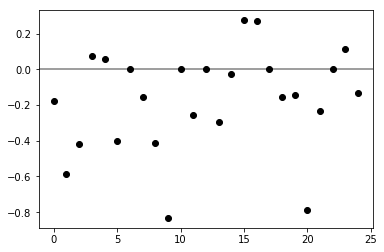

In [9]:
plt.plot(res['x'], "ko")
plt.axhline(0., color='k', alpha=0.5)

In [10]:
galrs_predicted = gcdist + np.dot(A, res['x'])
galrs_predicted.shape

(207194,)

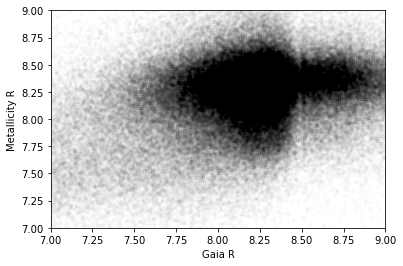

In [11]:
plt.plot(galrs, galrs_predicted, "k.", alpha=0.01)
plt.xlim(7., 9.)
plt.ylim(plt.xlim())
plt.xlabel("Gaia R")
plt.ylabel("Metallicity R")